Sources
* https://jhrcook.github.io/spotify-data-analysis/10_005_analyzing-my-streaming-history.html
* https://strftime.org/

In [115]:
# %pip install pandas numpy matplotlib seaborn rapidfuzz statsmodels

In [116]:
import os
from typing import cast, Literal
from pprint import pp
from datetime import datetime

import scipy
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator, StrMethodFormatter

import seaborn as sns
# sns.set_theme(style="white", context="notebook")
import matplotlib.pyplot as plt

pd.set_option("display.expand_frame_repr", False)

from preprocessing import read_file, extract_filtered, SongAttributes
from utils.fuzzy_searchers import *
from utils.generic_plots import Plots
from utils.filters import Filters
from utils.extract_from_timestamp import * 
from utils.smoothen import *
from utils.series_textwrap import *

In [117]:
# extract the "Spotify Extended Streaming History.zip" in a folder named data, sibling to this script

# data_folder = os.path.join(os.path.abspath(''), "niharika")
data_folder = os.path.join(os.path.abspath(''), "kirtika")
# data_folder = os.path.join(os.path.abspath(''), "prithika")
print(data_folder)
# only reading Audio History files
files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.startswith("Streaming_History_Audio")]
songs = [song for file in files for song in read_file(file)]

/home/divij/coding/projects/spotify-data-analysis/kirtika


In [118]:
filters: list[SongAttributes] = ["ts", "ms_played", "master_metadata_track_name", "master_metadata_album_artist_name", "master_metadata_album_album_name", "spotify_track_uri"]
filtered = [extract_filtered(song, filters) for song in songs]

In [119]:
df = pd.DataFrame(filtered)
df["ts"] = pd.to_datetime(df["ts"])
df.to_json("df.json", orient="records")

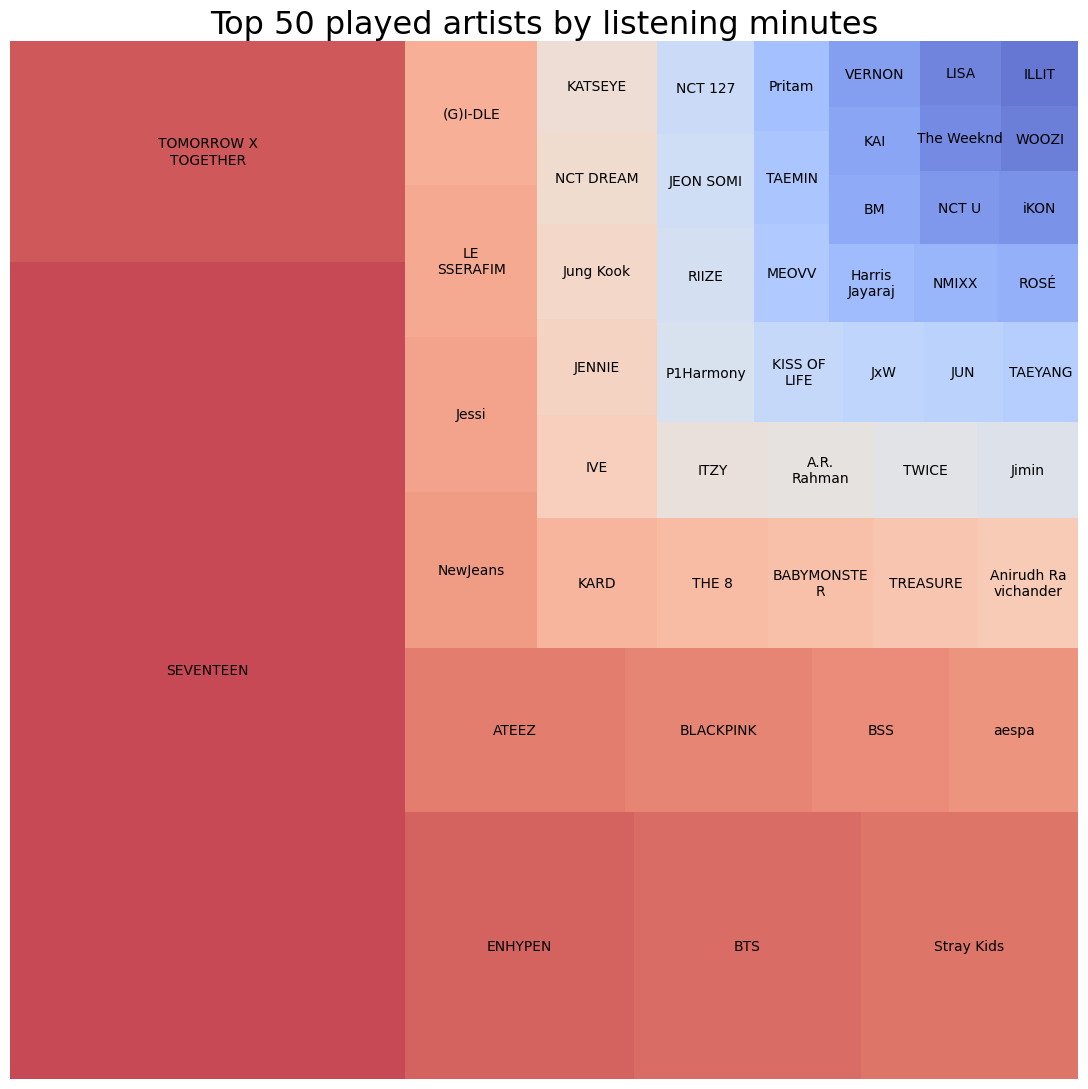

In [120]:
# Top artists by playtime
copy = df.copy(True)
grouped_by_artist_name = copy.groupby(copy["master_metadata_album_artist_name"])
time_listend = grouped_by_artist_name["ms_played"].sum()
time_listend = time_listend[time_listend != 0]
time_listend.sort_values(ascending=False, inplace=True)
time_listend_mins = time_listend.div(6e4)
time_listend_mins = cast(pd.Series, Filters.rows_gt(1, time_listend_mins))
index_wrap(time_listend_mins, 10)
Plots.plot_squarify(time_listend_mins[:50], "Top 50 played artists by listening minutes")

/home/divij/coding/projects/spotify-data-analysis/utils/generic_plots.py:29: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/divij/coding/projects/spotify-data-analysis/utils/generic_plots.py:29: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/divij/coding/projects/spotify-data-analysis/utils/generic_plots.py:29: UserWarning: Glyph 38588 (\N{CJK UNIFIED IDEOGRAPH-96BC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/divij/coding/projects/spotify-data-analysis/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/divij/coding/projects/spotify-data-analysis/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) miss

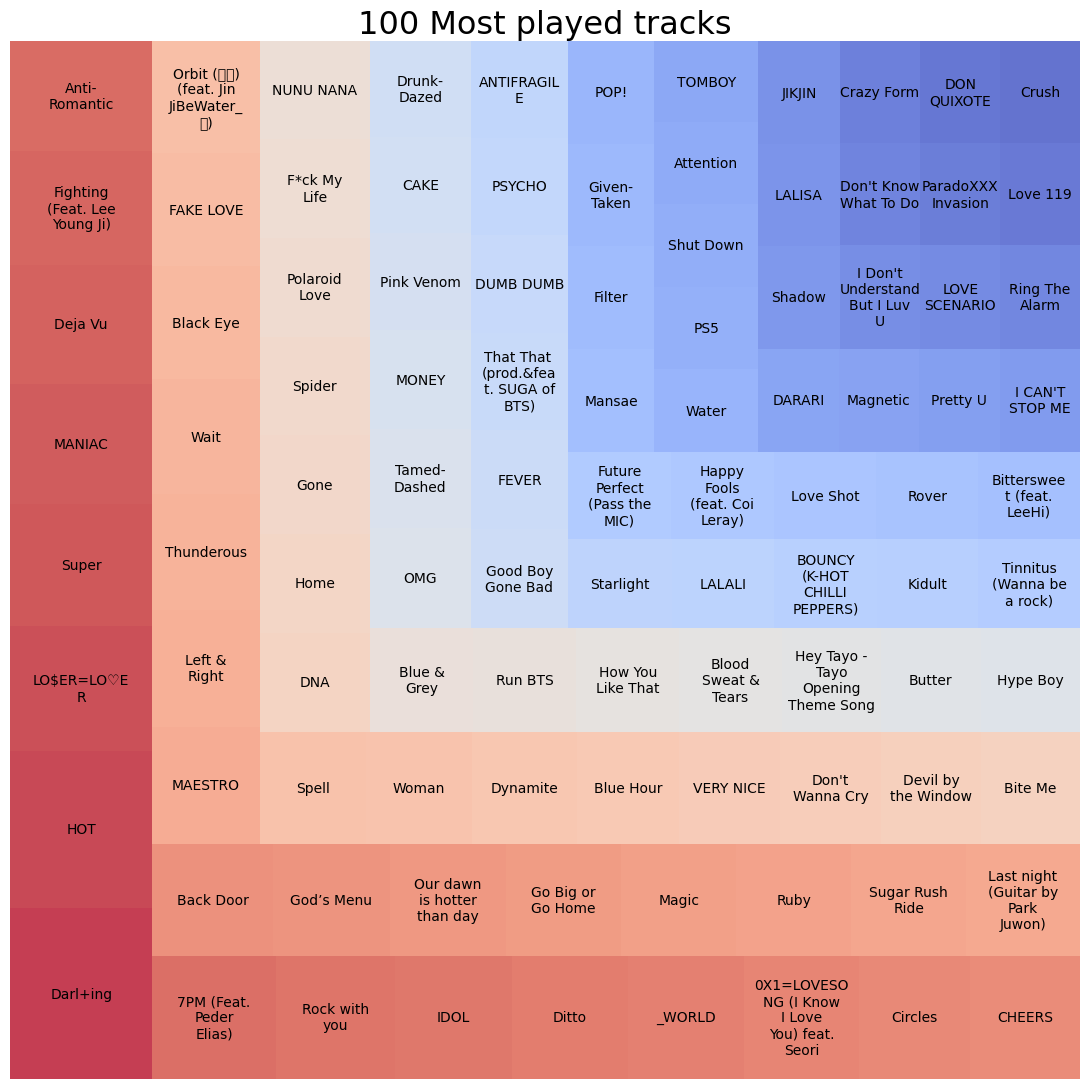

In [121]:
# Most played tracks
most_played_tracks = df.groupby(df["master_metadata_track_name"])["master_metadata_track_name"].count()
most_played_tracks.sort_values(ascending=False, inplace=True)
index_wrap(most_played_tracks, 10)
Plots.plot_squarify(most_played_tracks[:100], "100 Most played tracks")

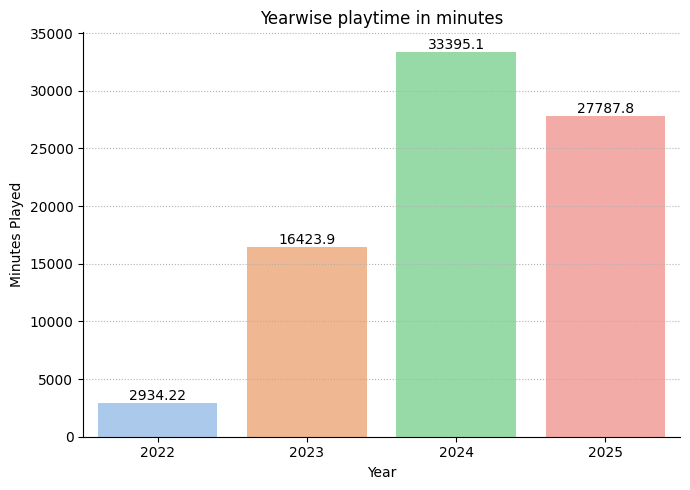

In [122]:
# yearwise listening minutes
with_dates = df.copy(True)
with_dates["ts"] = with_dates["ts"].apply(lambda ts: datetime.strftime(ts, "%Y"))
grouped_by_ts = with_dates.groupby("ts")
total_playtime = grouped_by_ts["ms_played"].sum()
total_playtime = total_playtime.div(6e4)
Plots.simple_barplot(total_playtime, "Yearwise playtime in minutes", "Year", "Minutes Played")

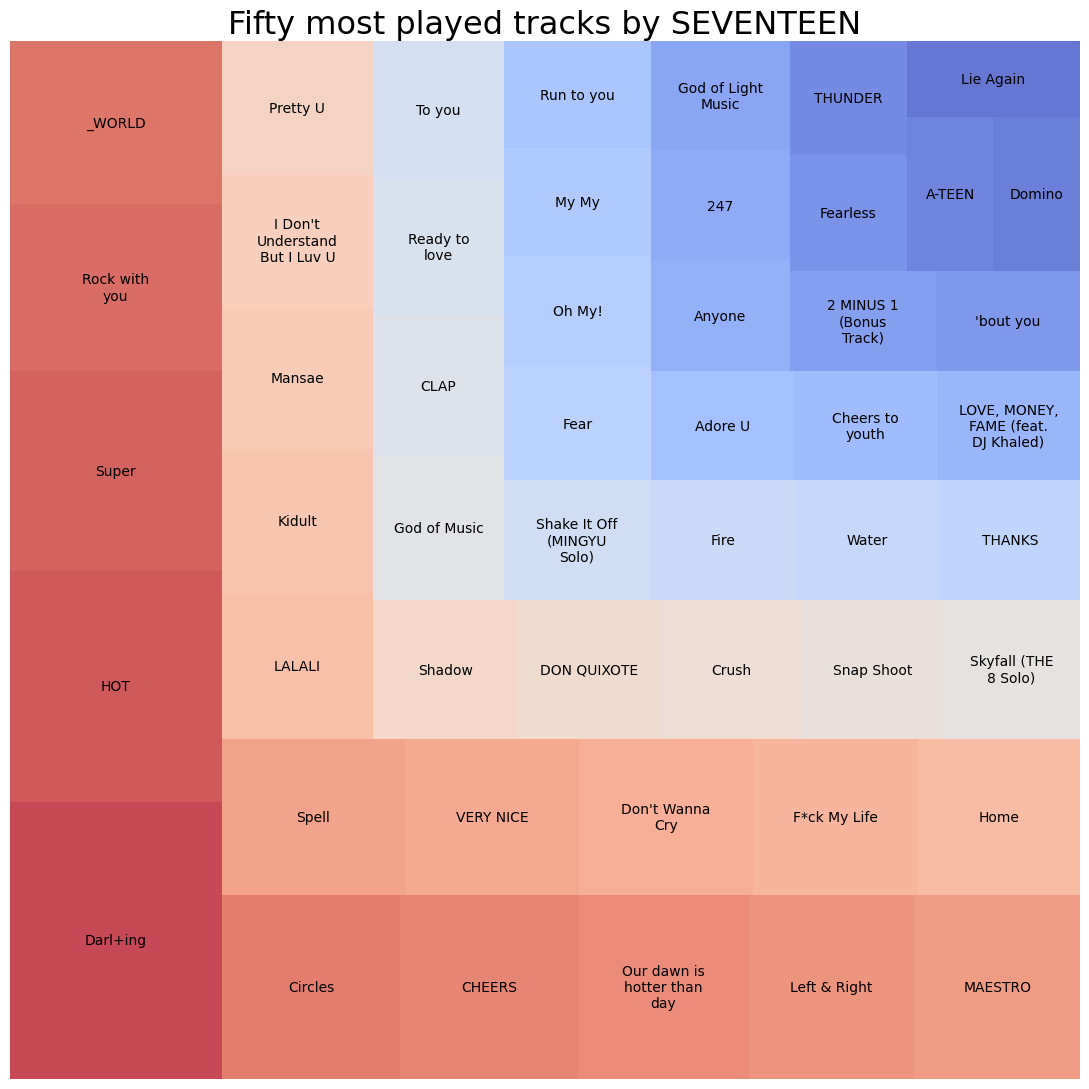

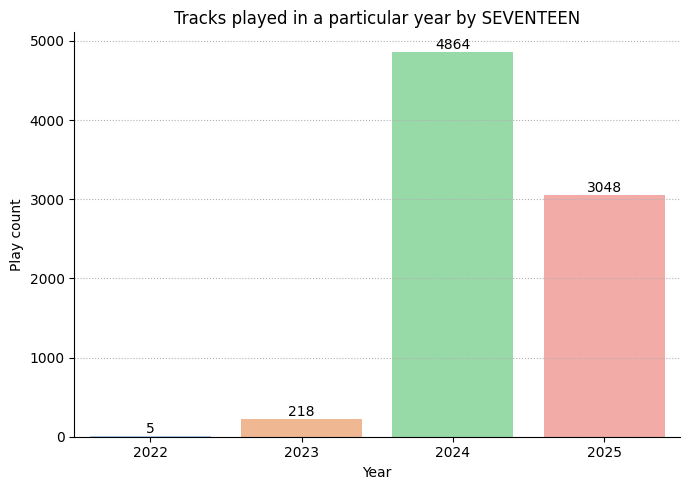

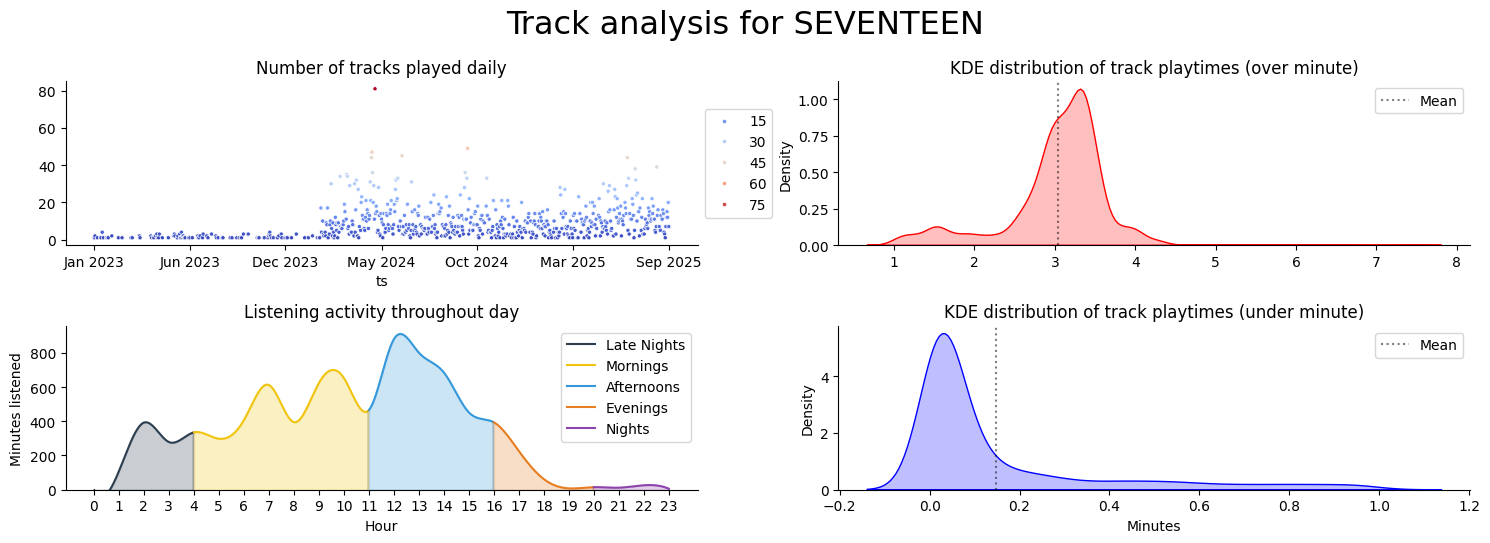

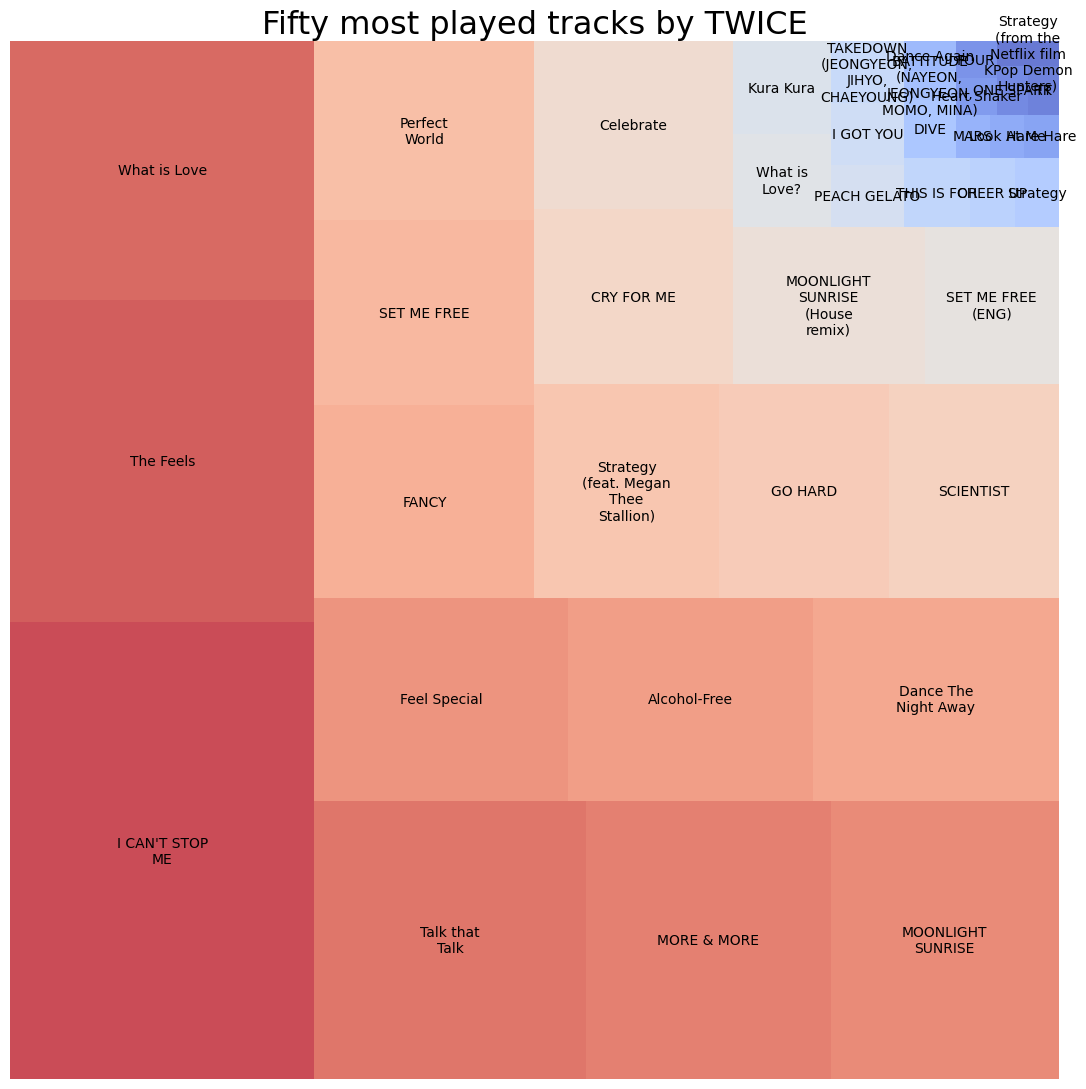

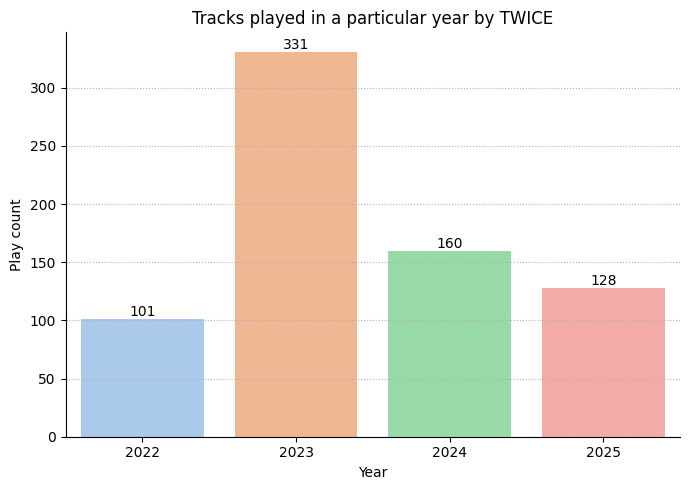

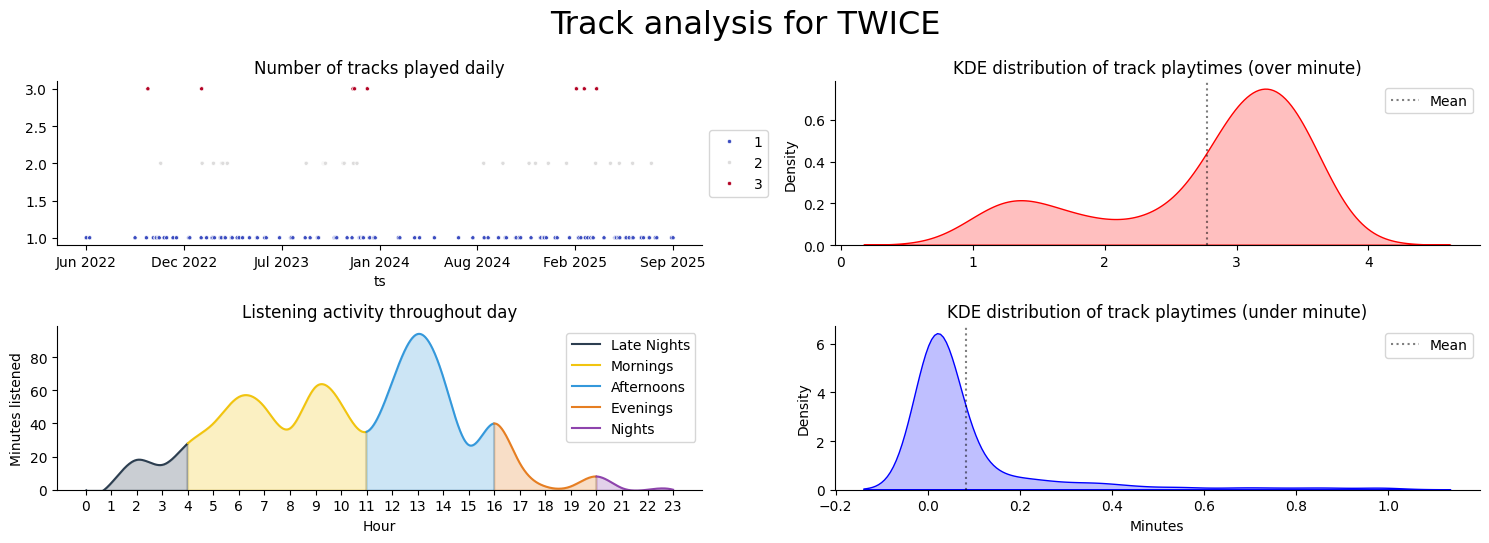

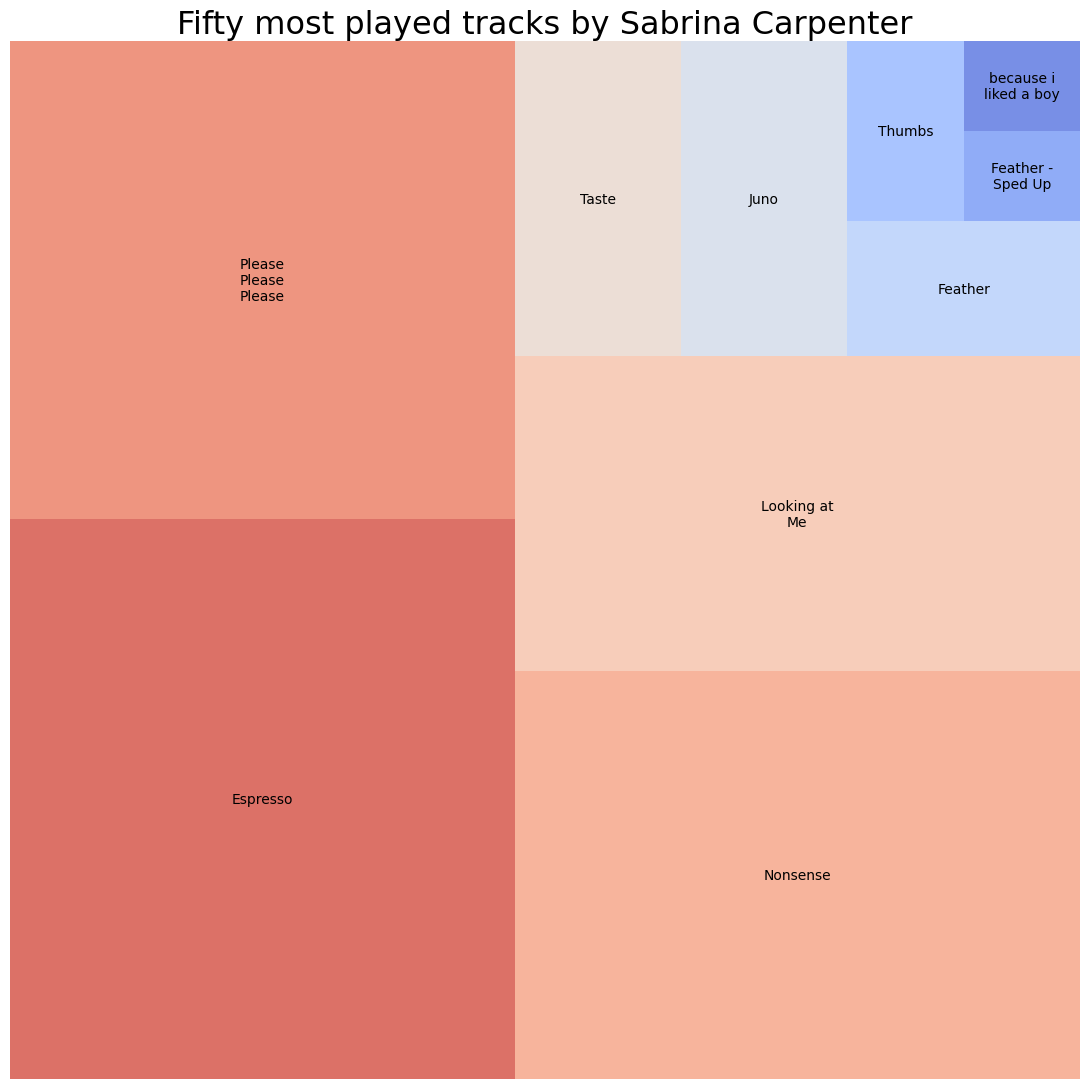

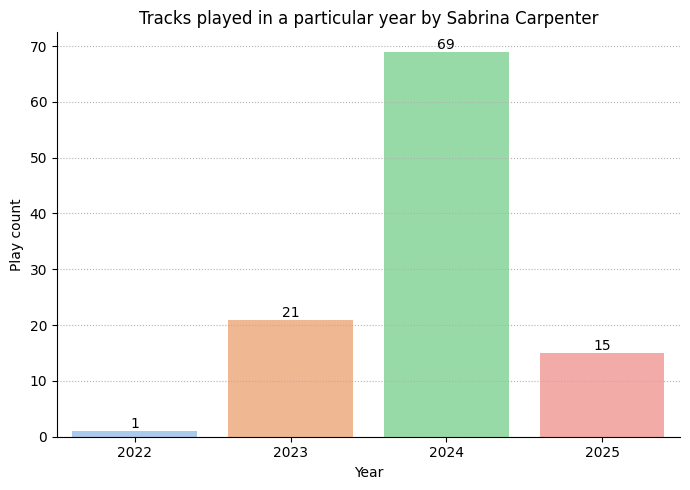

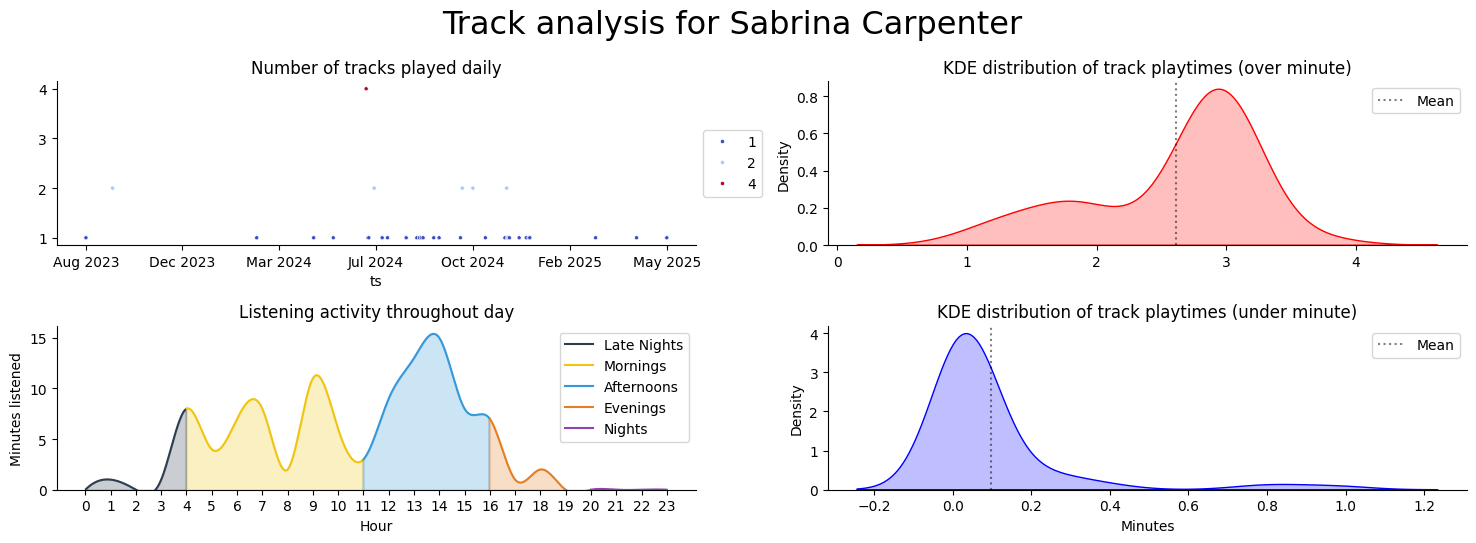

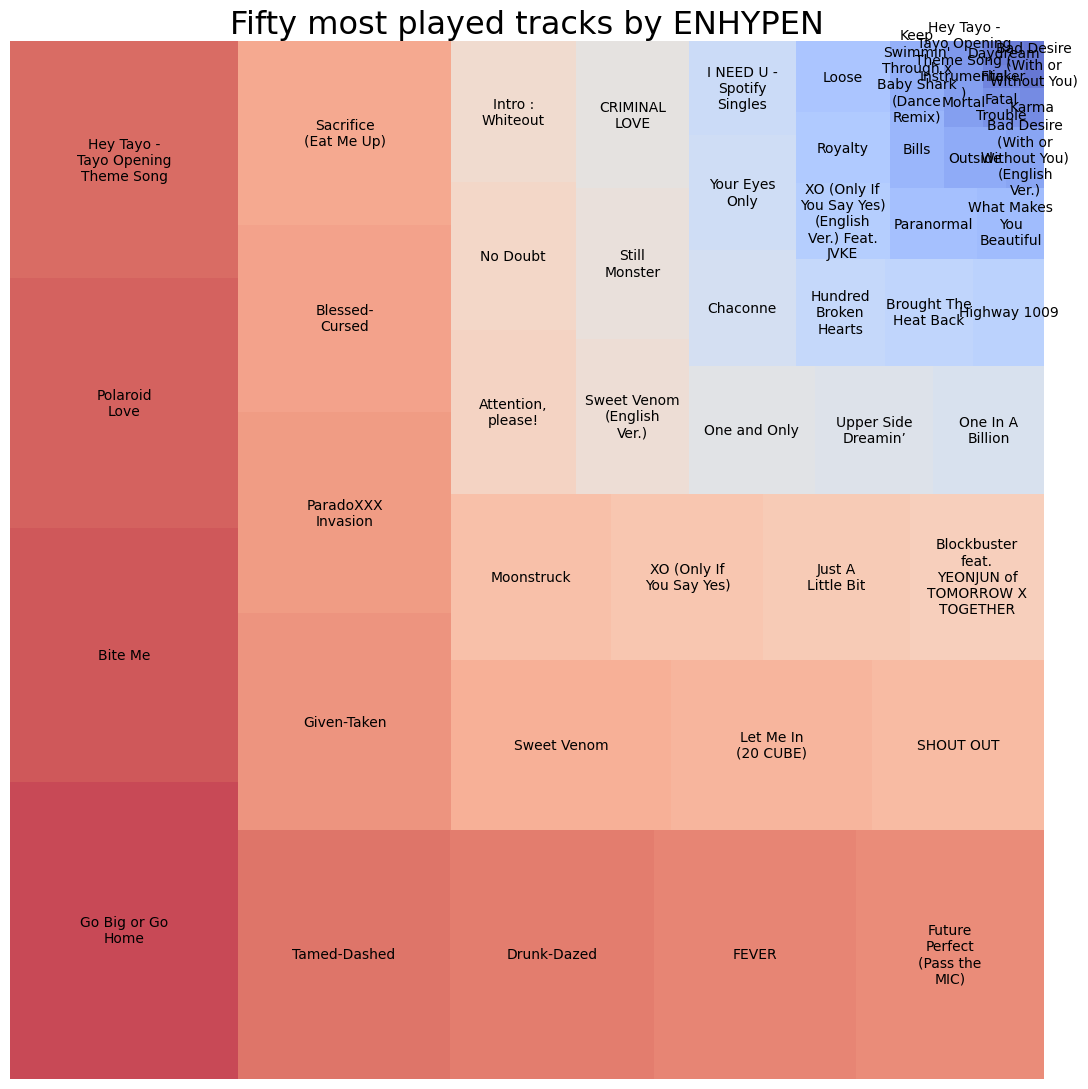

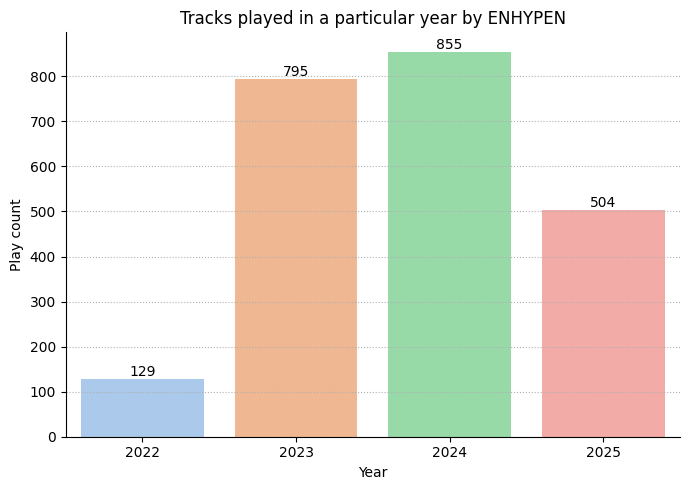

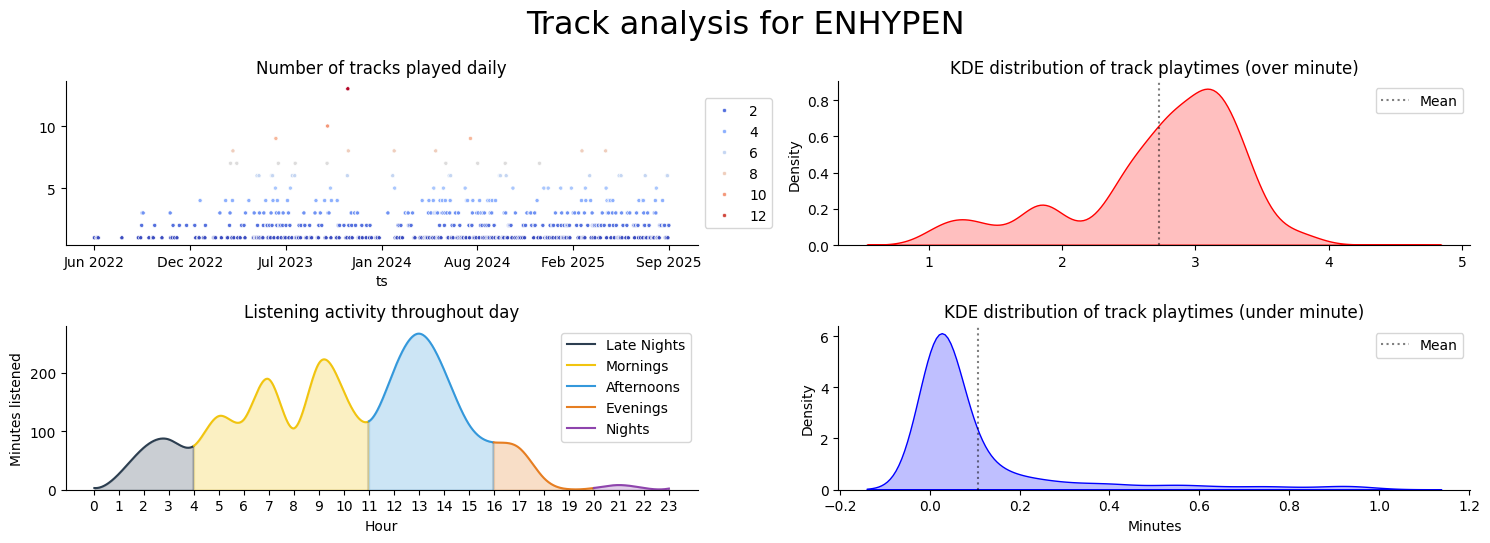

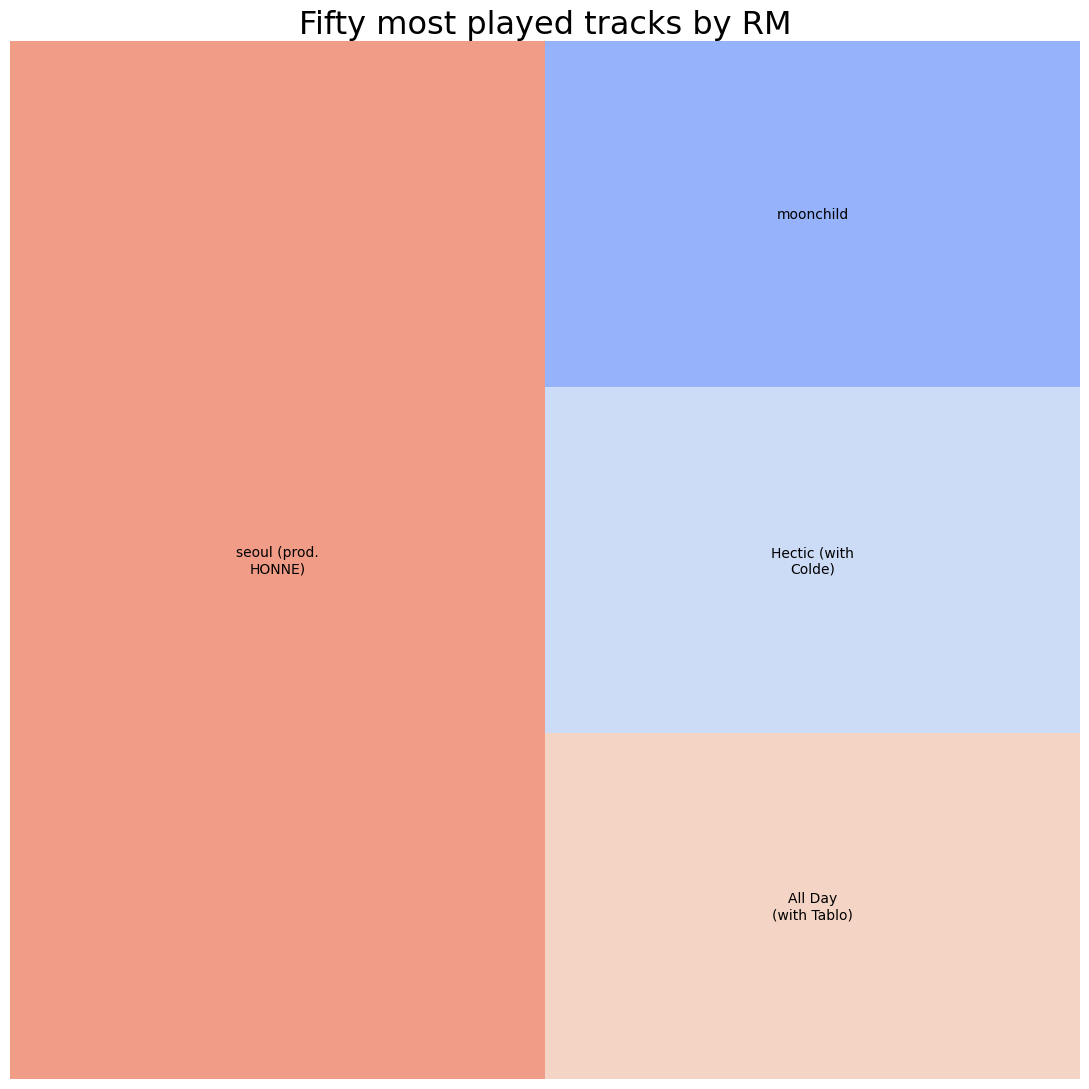

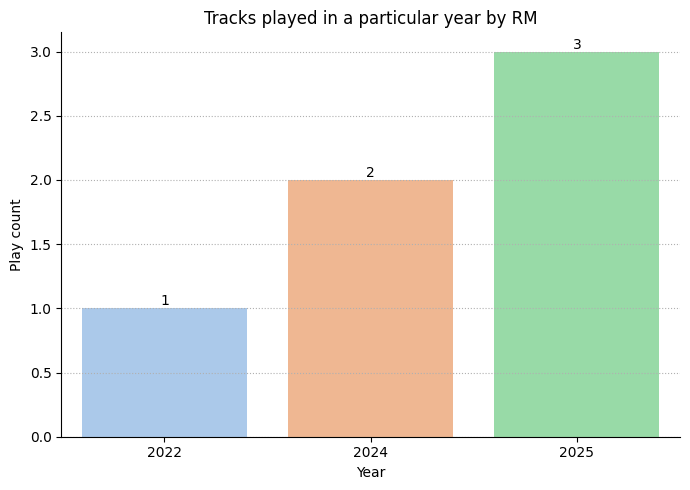

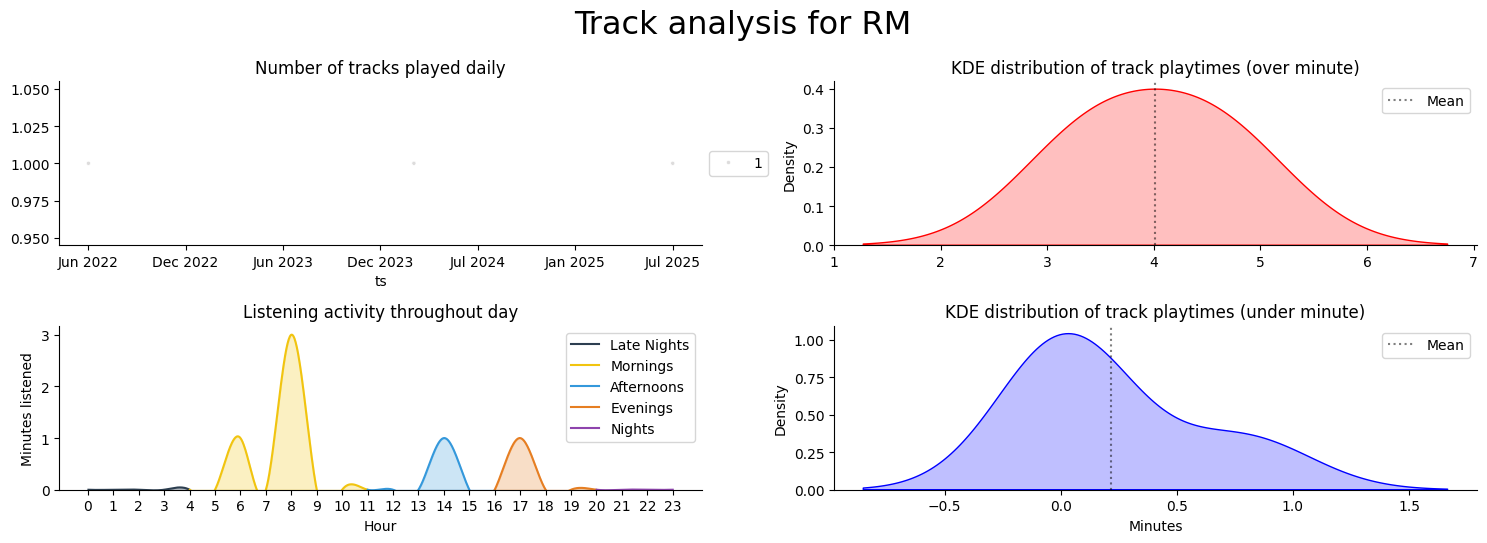

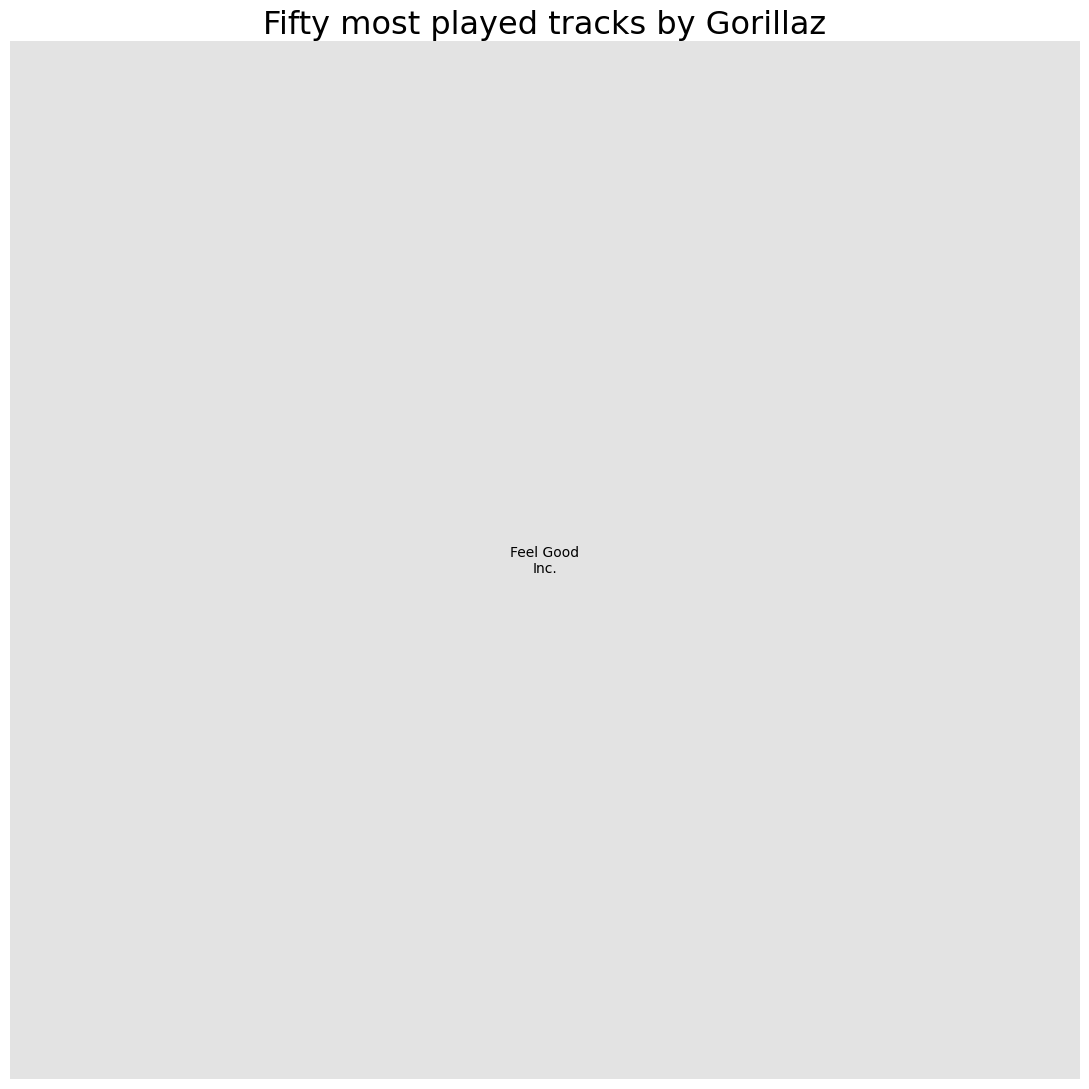

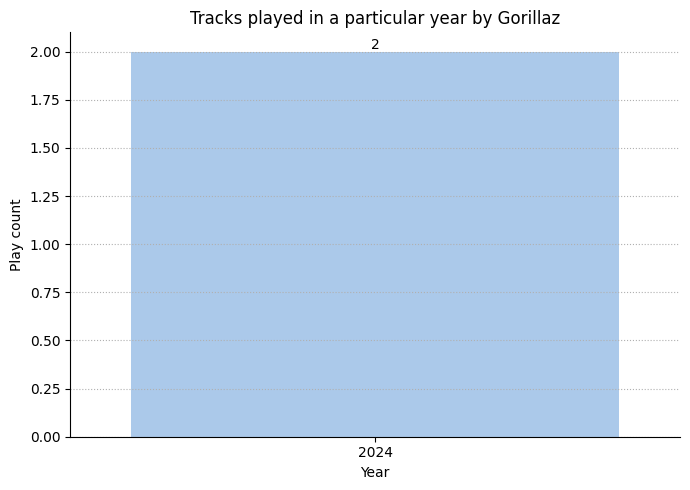

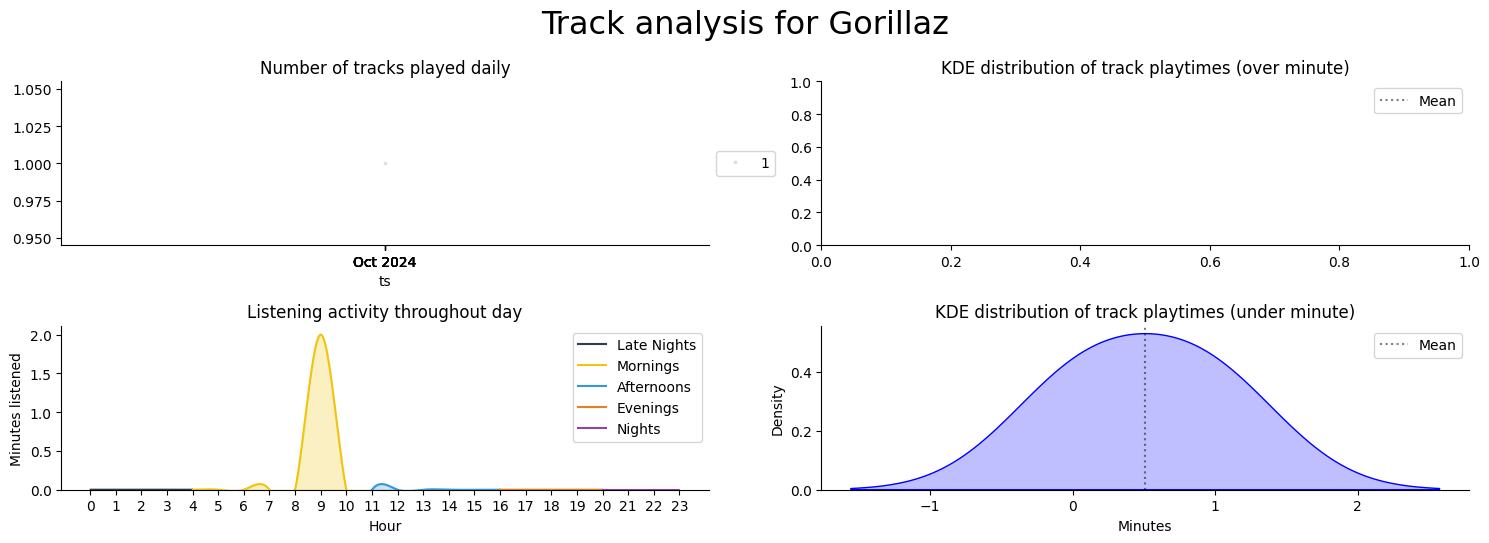

ValueError: Artist Michael Jackson is not in data

In [123]:
def analysis_per_artist(frame: pd.DataFrame, artist:str):
    if(artist not in frame["master_metadata_album_artist_name"].values):
        raise ValueError(f"Artist {artist} is not in data")

    artist_frame = frame[frame["master_metadata_album_artist_name"] == artist].copy(True)
    # grouped = artist_frame.groupby("master_metadata_album_artist_name")
    # changing ts to year
    artist_frame["year"] = artist_frame["ts"].apply(lambda ts: datetime.strftime(ts, "%Y"))

    # Top 50 played tracks
    played_track_count = (artist_frame
                          .groupby("master_metadata_track_name")
                          .size()
                          .sort_values(ascending=False))
    index_wrap(played_track_count, 12)
    Plots.plot_squarify(played_track_count[:50],f"Fifty most played tracks by {artist}")
    
    # Year wise play time
    yearwise_playtime = (artist_frame
                         .groupby("year")
                         .size())
    Plots.simple_barplot(yearwise_playtime, f"Tracks played in a particular year by {artist}", "Year", "Play count")
    
    fig, ax = plt.subplots(2, 2, figsize=(15,5.5))
    Plots.daily_tracks_graph(artist_frame, ax[0][0])
    Plots.track_playtime_kde_dist(artist_frame, ax[0][1], ax[1][1])
    Plots.daily_listening_activity(artist_frame, ax[1][0])
    fig.suptitle("Track analysis for " + artist, fontsize=23)
    fig.tight_layout()
    plt.show()
    
# analysis_per_artist(df, "SEVENTEEN")
# analysis_per_artist(df, "BTS")
# analysis_per_artist(df, "TOMORROW X TOGETHER")

analysis_per_artist(df, "SEVENTEEN")
analysis_per_artist(df, "TWICE")
analysis_per_artist(df, "Sabrina Carpenter")
analysis_per_artist(df, "ENHYPEN")
analysis_per_artist(df, "RM")
analysis_per_artist(df, "Gorillaz")
analysis_per_artist(df, "Michael Jackson")
analysis_per_artist(df, "Himesh Reshammiya")
analysis_per_artist(df, "Beyoncé")




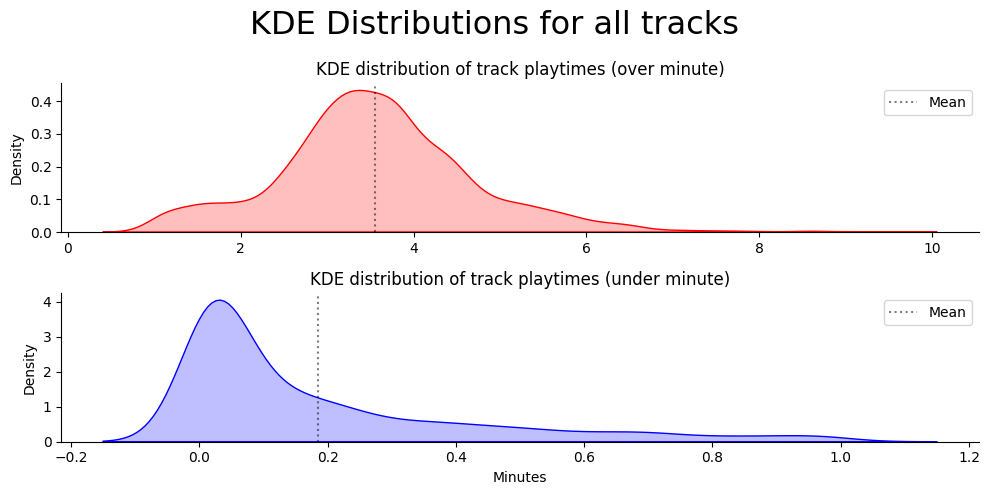

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
fig.suptitle("KDE Distributions for all tracks", fontsize=23)
Plots.track_playtime_kde_dist(df, ax[0], ax[1])
plt.tight_layout()
plt.show()

In [ ]:
# # days between first and last track record
# total_days = (
#     datetime.strptime(max_date, "%Y-%m-%d") - datetime.strptime(min_date, "%Y-%m-%d")
# ).days

/tmp/ipykernel_42178/4181062813.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  copy["month"] = copy["ts"].dt.to_period("M")


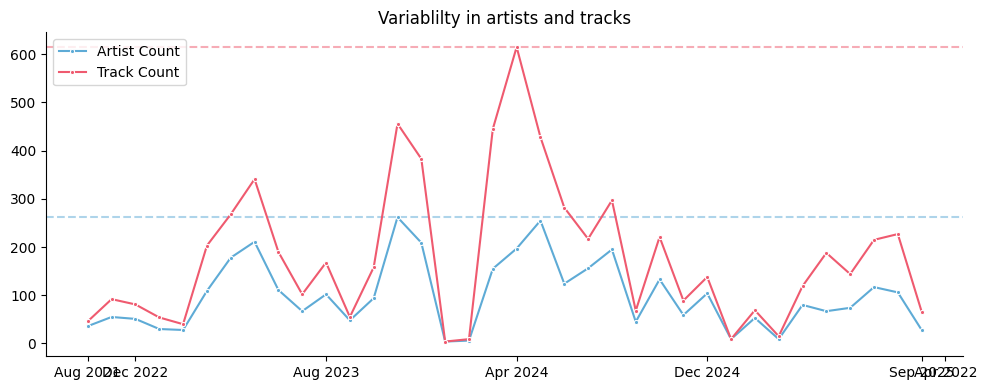

In [ ]:
# artists vs songs listend each month
# number of artists listend each month
copy = df[["ts","master_metadata_album_artist_name", "master_metadata_track_name"]].copy(True)
# copy["month-year"] = copy["ts"].apply(lambda ts: datetime.strftime(ts, "%b %Y"))
copy["month"] = copy["ts"].dt.to_period("M")
copy.sort_values("ts", inplace=True, ascending=True)

monthwise_unique_artists_count = copy.groupby("month")["master_metadata_album_artist_name"].nunique()
monthwise_unique_track_count = copy.groupby("month")["master_metadata_track_name"].nunique()
aggr = pd.concat([monthwise_unique_artists_count, monthwise_unique_track_count], axis=1)
aggr["month-year"] = aggr.index.strftime("%b %Y")
aggr.rename({"master_metadata_album_artist_name":"Artist Count", "master_metadata_track_name":"Track Count"}, inplace=True, axis=1)


fig, ax = plt.subplots(1, 1, figsize=(10, 4))

y1 = aggr["Artist Count"]
y2 = aggr["Track Count"]

ax.axhline(y1.max(), color="#5EABD6", alpha=0.5, linestyle='--')
ax.axhline(y2.max(), color="#EF5A6F", alpha=0.5, linestyle='--')

sns.lineplot(
    x=aggr["month-year"],
    y=y1,
    label=["Artist Count"],
    color="#5EABD6",
    marker=".",
    ax=ax
)
sns.lineplot(
    x=aggr["month-year"],
    y=y2,
    label=["Track Count"],
    color="#EF5A6F",
    marker=".",
    ax=ax
)
dates  = copy["ts"].apply(lambda ts: datetime.strftime(ts, "%Y-%m-%d"))
min_date = dates.min()
max_date = dates.max()

date_ticks = pd.date_range(start=min_date, end=max_date, periods=7, inclusive="both")
ax.set_xticks(date_ticks.strftime("%b %Y"), labels=[d.strftime("%b %Y") for d in date_ticks])
ax.legend(
    loc="upper left",
)
sns.despine()

plt.xlabel("")
plt.ylabel("")
plt.title("Variablilty in artists and tracks")
plt.tight_layout()
plt.show()

In [ ]:
copy = df.copy(True)

In [ ]:
copy["month"] = pd.to_datetime(copy["ts"]).apply(lambda ts: datetime.strftime(ts,"%b"))
may = copy[copy["month"] == "May"].copy(True)

In [ ]:
may["date"] = pd.to_datetime(copy["ts"]).apply(lambda ts: datetime.strftime(ts,"%d"))

In [ ]:
grouped = may.groupby("date").count().sort_values('ts', ascending=False)
grouped["ts"]

date
18    200
14    107
25     86
20     67
19     65
31     45
05     44
30     44
26     41
23     37
09     33
06     31
10     30
17     30
16     29
24     28
03     28
15     23
28     22
01     22
02     22
21     21
08     19
11     17
13     16
04     15
27     11
22      5
12      1
Name: ts, dtype: int64

In [ ]:
import os
from typing import cast, Literal
from pprint import pp
from datetime import datetime

import scipy
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator, StrMethodFormatter

import seaborn as sns
# sns.set_theme(style="white", context="notebook")
import matplotlib.pyplot as plt

pd.set_option("display.expand_frame_repr", False)

from preprocessing import read_file, extract_filtered, SongAttributes
from utils.fuzzy_searchers import *
from utils.generic_plots import Plots
from utils.filters import Filters
from utils.extract_from_timestamp import * 
from utils.smoothen import *
from utils.series_textwrap import *

In [ ]:
len(df[df["ms_played"] > 0])

7830